<a href="https://colab.research.google.com/github/DHI-GRAS/CTCN-workshop-2023/blob/main/notebooks/module_2_surface_water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surface water classification at scale

&nbsp;

This module corresponds to the methodology outlined in section 4.1 of the training manual and the 5.2 section explains this exercise step by step. It will include code examples as well as theoretical discussions around surface water mapping.

&nbsp;

**Upon completion of this notebook you will be able to:**

1.   Import different ImageCollection's and apply filters to the data.
2.   Remove clouds from Sentinel-2 imagery (optical data).
3.   Calculate spectral indices (NDVI, NDWI).
5.   Calculate water probability for optical and SAR data.
6.   Visualize your results on an interactive Map.
7.   Export your results locally.






# Introduction

The mapping of land-water from satellite imagery has a long heritage and today high-resolution products are available globally. The European Space Agencies (ESA) Copernicus Sentinel-1(SAR) and Sentinel-2 (optical) missions are available globally free of charge and with short latency. They have proven well adept at mapping surface water. In addition, advances in computational power and data accessibility (e.g. Google Earth Engine) enable the rapid and automated production of these land-water boundaries at scale.

Thus, a workflow was developed (see figure below) that uses both **optical and SAR** imagery to determine land-water classification. We can use this workflow for analysis of coastal and river morphology.

The approach integrates all multi-temporal observations from **Sentinel-1** and **Sentinel-2** to map surface water at monthly intervals across the time-series. 

> **TIP:**  The original publication can be read here: https://www.mdpi.com/2072-4292/13/9/1663/htm
  


The below image represents the workflow for Land-water classification methodology. It provides a good overview how we will process data in this notebook. **Do not worry, we will explain each step further down!**

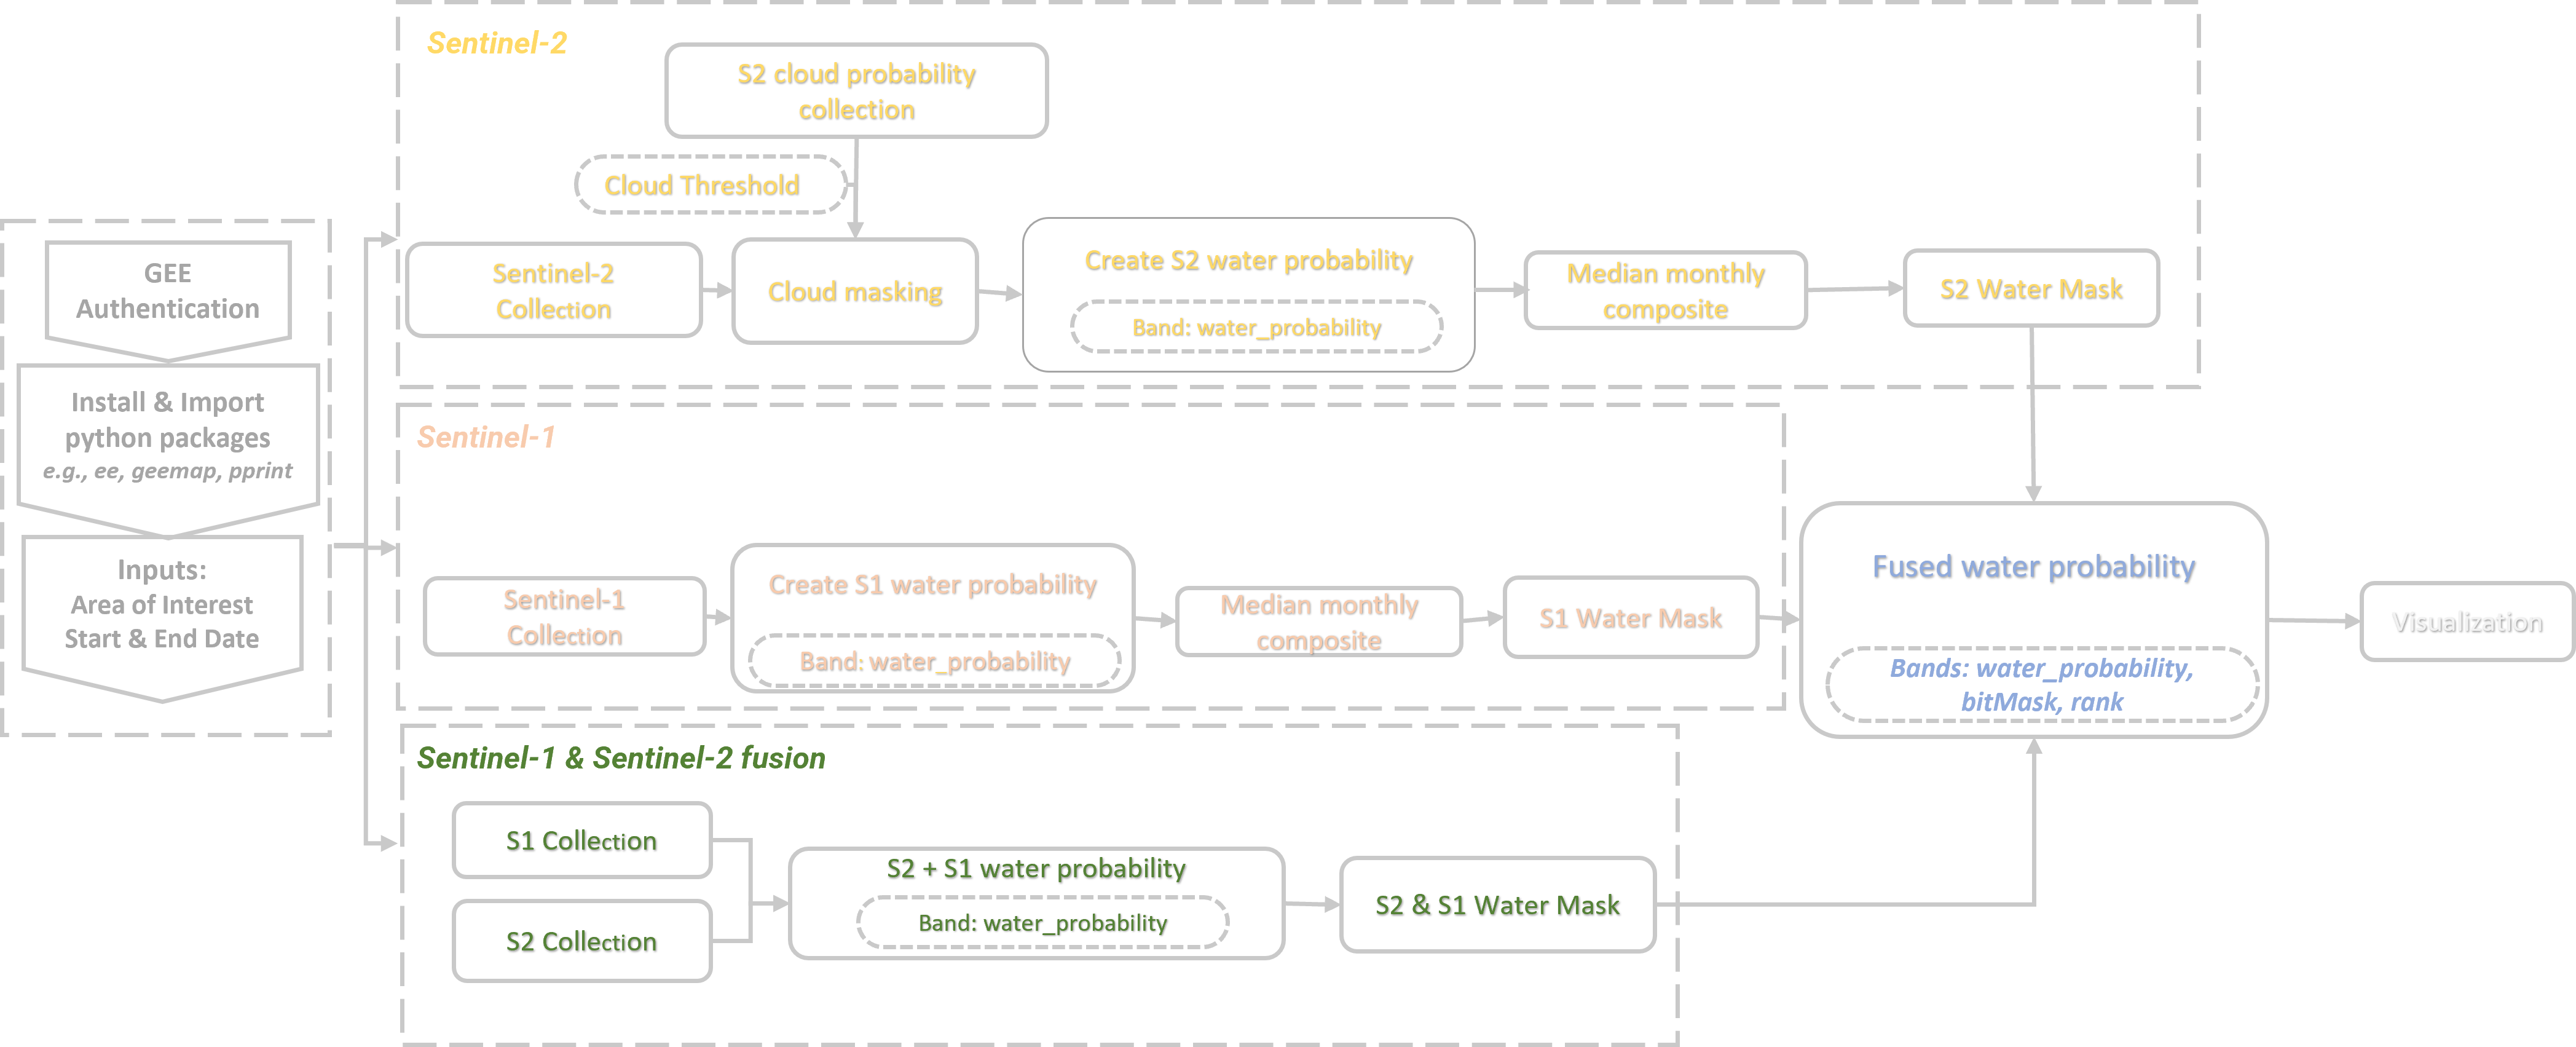

# GEE Authentication
First, we are going to set up our working environment by installing and  importing any dependencies for our analysis. This includes the core GEE API, as well as some additional libraries that help us interact with the data in a Python environment. 


In [1]:
# Install the earthengine-api.
!pip install -q earthengine-api

# Import the Earth Engine library.
import ee

# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8poW4lcD6mxyMTo0rAfTI2xExMMyfrvPRIQXL3VoUwA&tc=1WuwlWb-vmzFYApvtwDqojMP6mGTDJIWg27KwBpvGXo&cc=TTS-2wsThe1L2rimvwmIiOtdhb77a8jOQGJL5TR4nbQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VOCGjME7WcdVmQAF2IABDg3yE0XNkPX1237ntUELUCxt-6CtEPti-M

Successfully saved authorization token.


# Install and import the python libraries

The following cell imports the geemap library used in this notebook. With geemap imported, your notebook is now ready to visualize GEE datasets interactively.  

In [2]:
# install geemap library
%%capture
!pip install geemap

In [3]:
# import geemap library
import geemap

> **TIP:**  You can read more about geemap package [here](https://geemap.org/)

# Define our area of interest (AOI)


This will be the AOI where we will build our landwater classification and explore the data.    

You are free to modify the AOI, but it is good practice to work with a small area while prototyping methods. Then, once the workflow is established, scaling to a larger area. This is to optimize the speed of development and reduce the compute requirements.  

GEE is designed to scale so this is a less of a problem, yet you may still experience memory issues if you scale too quickly. 


In [10]:
# Define AOI
AOI = ee.Geometry.Polygon([[[89.41952939465034, 23.360648430345197],
                            [89.41952939465034, 22.058389972460756],
                            [91.13339658215034, 22.058389972460756],
                            [91.13339658215034, 23.360648430345197]]])

# Add the AOI to the Map.
Map = geemap.Map(height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.addLayer(AOI, {}, "AOI")
Map.centerObject(AOI, 7)
Map

Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…


# 1) Sentinel-2 processing

1.   Set a date range for our analysis.
2.   Select the Sentinel-2 (L1C) image collection.
3.   Filter it by date, and AOI.
4.   Make a median composite.
5.   Apply cloud masking.
6.   Create water index.
7.   Wrap the process in a function.


First, we're going to get some Sentinel-2 Data over our AOI and select SartDate and EndDate.    
>*Q: Can you guess how many images we will get for this area from Sentinel-2 mission?*

In [11]:
## Let's set some dates for testing - January 2022.
startDate = '2022-02-01'
endDate = '2022-03-01'

## First we'll get some Sentinel-2 data
s2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filter([
           ee.Filter.date(startDate, endDate),
           ee.Filter.bounds(AOI)
           ])


Let's get answer:  We will print the number of images in the month.

When printing we have to use the .getInfo() function to get the data client side, otherwise GEE will return the serialized request for the object (which isn't very readable!).
> **TIP**: If you understand more about the client server  check [here](https://developers.google.com/earth-engine/guides/client_server). 


In [12]:
number_of_s2_images = s2.size()
print(f'{number_of_s2_images.getInfo()} Sentinel-2 images between {startDate} and {endDate}')

52 Sentinel-2 images between 2022-02-01 and 2022-03-01


In [20]:
## Finally, make a S2 composite and clip to our AOI. Easy!
s2_median = s2.median().clip(AOI)

## Let's visualise it.
Map = geemap.Map( height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 8)
Map.addLayer(AOI, {}, 'AOI')
Map.addLayer(s2_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3500},'S2 median ')
Map

Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

We can see that in February 2022 there are quite a few clouds impacting our analysis - we can NOT "see" through them. It's standard practice to remove these with cloud masks, although unfortunately no methods are perfect. Let's try to improve this composite using the 's2 cloudless' cloud mask. 

In [21]:
## Get the s2 cloudless image collection and apply data and bounds filter.
s2_cloudless = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filter([
           ee.Filter.date(startDate, endDate),
           ee.Filter.bounds(AOI)
           ])


## Join the cloudless collection to our s2 collection, using the 'system:index' 
##  as the condition.
join = ee.Join.inner().apply(**{
        'primary': s2,
        'secondary': s2_cloudless,
        'condition': ee.Filter.equals(**{'leftField': 'system:index', 
                                         'rightField': 'system:index'})
        })


# To make use of the joined images in the output FeatureCollection, map() a 
# combining function over the output. For example, the matching images can be 
# stacked together such that the cloud bands are added to the image data:
def merge_collections (feature):
  return ee.Image(feature.get('primary')).addBands(feature.get('secondary'))

s2_cloudless_merged = ee.ImageCollection(join.map(merge_collections))


## We can check the bands have been added by printing the bandNames of the first image.
## You can see 'probability' band has been added to the original s2 bands.
print(s2_cloudless_merged.first().bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'probability']


In [23]:
## We'll map a function across all images that updates the mask according to the 
##  cloud probability threshold we have choesen. 
probability_threshold = 40

s2_cloud_masked = s2_cloudless_merged.map(
    lambda image: image.updateMask(image.select('probability').lt(probability_threshold))) 

## Let's visualize the new composite.
s2_cloud_masked_median = s2_cloud_masked.median().clip(AOI)

## Let's visualise it.
Map = geemap.Map( height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 8)
Map.addLayer(AOI, {}, 'AOI')
left_layer = geemap.ee_tile_layer(s2_median, {'bands': ['B4', 'B3', 'B2'], 
                                              'min': 0, 'max': 3500},'S2 median ')
right_layer = geemap.ee_tile_layer(s2_cloud_masked_median, 
                                   {'bands': ['B4', 'B3', 'B2'], 
                                    'min': 0, 'max': 3500},'S2 Cloud Masked Median ')
Map.split_map(left_layer, right_layer)
Map


Map(center=[22.710768669887795, 90.2764629884002], controls=(ZoomControl(options=['position', 'zoom_in_text', …


> **TIP**: It looks much better. Most of the clouds have been removed. Move the panel to see where clouds were removed.




The last step is to create a water and vegetation index and apply a threshold to get a water mask for that month.

We'll define a function that creates a water probability score. It's a 
pretrained logistic regression expression that takes the Normalised 
Difference Vegetation Index (NDVI) and the Normalised Difference Water
Index (NDWI) as inputs.

Creating NDVI gets the difference in value between particular bands (which in this case represent different segments of the visible electromagnetic spectrum).

In [24]:
def add_s2_water_probability (image):
  ## Create the required input bands.
  ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
  ndwi = image.normalizedDifference(['B3','B8']).rename('ndwi')

  ## Add them and compute the water probability.
  water_probability = image.addBands([ndvi, ndwi]).expression(
      "1 / (1 + exp(- (0.845 + (2.14 * b('ndvi')) + (13.5 * b('ndwi')))))"
      ).multiply(100).rename(['water_probability'])

  ## return the original image + the water probability.
  return image.addBands([water_probability, ndvi, ndwi])

## We'll map that function over our cloud masked collection
s2_water_collection = s2_cloud_masked.map(add_s2_water_probability)


Again, we can print to check the band was added.
You can see **water_probability, NDVI and NDVI** bands have been added to the original s2 bands.

In [25]:
print(s2_water_collection.first().bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'probability', 'water_probability', 'ndvi', 'ndwi']


In [26]:
## Let's create the median composite.
s2_water_median = s2_water_collection.median().clip(AOI)

## visualisation palette taken from https://colorbrewer2.org/
BrGr_palette = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5',
                '#c7eae5','#80cdc1','#35978f','#01665e','#003c30']


## and visualise the RGB and the water probability.
Map = geemap.Map(center=[21, 90], zoom=7, height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')

Map.addLayer(s2_water_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3500},'S2 RGB median ')
Map.addLayer(s2_water_median,{'bands': ['ndvi'], 'min': -1, 'max': 1, 
                          'palette':['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641']},'S2 NDVI')
Map.addLayer(s2_water_median,{'bands': ['ndwi'], 'min': -1, 'max': 1, 
                          'palette':['#eff3ff','#08519c']},'S2 NDWI')
Map.addLayer(s2_water_median, {'bands': ['water_probability'], 'min': 0, 'max': 100, 
                           'palette': BrGr_palette},'S2 water median ')
Map


Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

> **TIP:** Remember to use the layer options to see all layers, e.g., water probability and RGB!

The water probability returns a score 0-100. We can threshold this to create binary land/water mask.

In [27]:
water_probability_threshold = 60

## Any value greater than our threshold is water
water_mask = s2_water_median.select('water_probability').gt(water_probability_threshold)


## Visualise it.
Map = geemap.Map(height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')
Map.addLayer(s2_water_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000},'S2 RGB median ')
Map.addLayer(s2_water_median, {'bands': ['water_probability'], 'min': 0, 'max': 100,'palette': BrGr_palette},'Water Probability')
Map.addLayer(water_mask, {'min': 0, 'max': 1, 'palette': ['#bf812d', '#80cdc1']},'Water Mask')
Map


Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

>**TIP:** Try to change the water probability threshold from 60 to another value and re-run the cell 

Nice!

 Summary what we have done:
Firstly, we've filtered all the sentinel 2 imagery to our AOI and date range. This was a total of 52 images.
Then, we created a median composite and visualised it and found that clouds we're impacting our results - we couldn't see beneath them. Therefore we learnt how to mask the clouds using the 's2-cloudless' collection and created a new median composite which looked much better.
Lastly, we computed a water probability score and visualised that. Then learnt how to turn that into a binary water-land mask.



We can wrap these methods into some nice functions so we can reuse them later and create more complex workflows.

In [28]:
## This function returns a masked sentinel-2 collection
def get_cloud_masked_s2(start_date, end_date, AOI, cloud_threshold):
  s2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filter([
           ee.Filter.date(start_date, end_date),
           ee.Filter.bounds(AOI)
           ])
  
  s2_cloudless = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filter([
            ee.Filter.date(start_date, end_date),
            ee.Filter.bounds(AOI)
            ])

  join = ee.Join.inner().apply(**{
        'primary': s2,
        'secondary': s2_cloudless,
        'condition': ee.Filter.equals(**{'leftField': 'system:index','rightField': 'system:index'})
        })
  
  merged = ee.ImageCollection(
      join.map(lambda feature: ee.Image(feature.get('primary')).addBands(feature.get('secondary')))
  )

  cloud_masked = merged.map(
    lambda image: image.updateMask(image.select('probability').lt(cloud_threshold))
    ) 

  return cloud_masked

In [29]:
## We can now create the same workflow much more concisely. 
startDate = '2022-02-01'
endDate = '2022-03-01'

s2 = get_cloud_masked_s2(startDate, endDate, AOI, cloud_threshold=40)
s2_median_water = s2.map(add_s2_water_probability).median().clip(AOI)

## Visualise it.
Map = geemap.Map(height=400, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')
Map.addLayer(s2_median_water, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3500},'S2 RGB median ')
Map.addLayer(s2_median_water, {'bands': ['water_probability'], 'min': 0, 'max': 100, 'palette': BrGr_palette},'S2 water median ')
Map


Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

#2) Sentinel-1 processing 

Sentinel-1 GRD (Ground Range Detected) collection does not require cloud masking. However, there are other pre-processing steps that should be completed before using it for analysis. Fortunately, GEE has already done much of this work for us. 

>**TIP**: 
* You can see in the description of the [collection](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD#description) that each scene was pre-processed with Sentinel-1 Toolbox using the following steps:
  *   Thermal noise removal
  *   Radiometric calibration
  *   Terrain correction using SRTM 30 or ASTER DEM for areas greater than 60 degrees latitude, where SRTM is not available.
* Further SAR processing is optional depending on the environment. A good overview can be found [here](https://www.mdpi.com/2072-4292/13/10/1954) . 

The collection is updated daily and new assets are ingested within two days after they become available. 
 

In [30]:
startDate = '2022-02-01'
endDate = '2022-03-01'


## We will apply this one additional preprocessing step where we remove pixels
## that have a more extreme angle. Sometimes they can be problematic.
def mask_angle_30_45 (image):
  angle = image.select('angle')
  return image.updateMask(angle.gt(30.63993).And(angle.lt(45.23993)))


## We will wrap it in a function straight away for easy use later.
def get_s1 (start_date, end_date, AOI):
  return (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(AOI)
           .filterDate(start_date, end_date)
           .filter([
               ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'),
               ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'),
               ee.Filter.eq('instrumentMode', 'IW')
               ])
           .map(mask_angle_30_45))


## We will define a water probability function for Sentinel-1.
def add_s1_water_probability (image):
  ## Compute the water probability.
  water_probability = image.expression(
      "1 / (1 + exp(- (-5.8 + (-0.415 * b('VV')))))"
      ).multiply(100).rename(['water_probability'])

  ## return the original image + the water probability.
  return image.addBands(water_probability)


In [31]:
## Let's use those functions to create a Sentinel-1 water probability.
s1 = get_s1(startDate, endDate, AOI)
s1_median_water = add_s1_water_probability(s1.median()).clip(AOI)

## Visualise it. Look at the difference between the VV and VH bands. 
Map = geemap.Map( height=400, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')
Map.addLayer(s2_median_water, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000},'S2 RGB median ')
Map.addLayer(s1_median_water, {'bands': ['VH'], 'min': -30, 'max': -10},'S1 VH median ')
Map.addLayer(s1_median_water, {'bands': ['VV'], 'min': -25, 'max': -5},'S1 VV median ')
Map.addLayer(s1_median_water, {'bands': ['water_probability'], 'min': 0, 'max': 100, 
                               'palette': BrGr_palette},'S1 water median ')
Map

Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

#3) Sentinel-1 & Sentinel-2 fusion  

We have now created two independent water probability scores; using Sentinel-1 and Sentinel-2. Now we want to make a "fused" probability that uses the information from both missions together. 

We also need to consider that sometimes Sentinel-2 data may not be available at all, if it is cloudy for the duration of the time period, for example during the monsoon season. 

In [32]:
## we can get the data easily using the function we've already created.
s1 = get_s1(startDate, endDate, AOI)
s2 = get_cloud_masked_s2(startDate, endDate, AOI, cloud_threshold=40)

## and stack the imagery using .addBands().
s1_s2_stack = s1.median().addBands(s2.median()).clip(AOI)

## let's check we have S1 and s2 bands in our image.
print(s1_s2_stack.bandNames().getInfo())

['VV', 'VH', 'angle', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'probability']


In [33]:
## Now we need the last water probability function for S1 and S2.

def add_s1_s2_water_probability (image):
  ## Use only the pixels where we have Sentinel-1 and Sentinel-2 data.
  mask = image.select('B8').mask().And(image.select('VV'))

  ## Create the required input bands.
  ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
  ndwi = image.normalizedDifference(['B3','B8']).rename('ndwi')

  ## Add them, mask the image, and compute the water probability.
  water_probability = image.addBands([ndvi, ndwi]).updateMask(mask).expression(
      "1 / (1 + exp(- (-3.25 + (-0.23 * b('VV'))  + (4.17 * b('ndvi')) + (9.5 * b('ndwi')))))"
      ).multiply(100).rename(['water_probability'])

  ## return the original image + the water probability.
  return image.addBands(water_probability)


In [34]:
## compute the probability
s1_s2_water = add_s1_s2_water_probability(s1_s2_stack)

## Visualise it with the other probabilities. 
Map = geemap.Map(height= 400, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')
Map.addLayer(s2_median_water, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000},'s2 RGB median ')
Map.addLayer(s1_median_water, {'bands': ['VV'], 'min': -25, 'max': -5},'s1 VV median ')
Map.addLayer(s1_median_water, {'bands': ['water_probability'], 'min': 0, 'max': 100, 
                               'palette': BrGr_palette},'s1 water median ')
Map.addLayer(s2_median_water, {'bands': ['water_probability'], 'min': 0, 'max': 100, 
                               'palette': BrGr_palette},'s2 water median ')
Map.addLayer(s1_s2_water, {'bands': ['water_probability'], 'min': 0, 'max': 100, 
                           'palette':BrGr_palette},'S1_S2_water_prob')
Map


Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

# 4) Combine and rank the output

Here we fuse the multiple sensors into 1 image with 2 bands.  


1.   The first is the fused water probability.  
2.   The second is a "bitmask" that tells us which sensor combination was used.  

In [35]:
def fuse_water_probabilities (s1, s2, s1_s2):
  s1_score = 1
  s2_score = 2
  s1_s2_score = 3
  
  s1_ranked = s1.addBands(ee.Image(s1_score).updateMask(s1.mask()).rename('rank').byte())
  s2_ranked = s2.addBands(ee.Image(s2_score).updateMask(s2.mask()).rename('rank').byte())
  s1_s2_ranked = s1_s2.addBands(ee.Image(s1_s2_score).updateMask(s1_s2.mask()).rename('rank').byte())

  return (ee.ImageCollection([s1_ranked, s2_ranked, s1_s2_ranked])
                     .cast(**{'bandTypes': {'water_probability': 'uint8', 'rank': 'uint8'}, 
                              'bandOrder': ['water_probability', 'rank']})
                     .qualityMosaic('rank')
                     .select(['water_probability', 'rank'], ['water_probability', 'bitMask'])
                    #  .toByte()
  )

Let's execute the function with the inputs we've created previously.

In [36]:
import pprint
fused_water_probability = fuse_water_probabilities(
    s1_median_water.select('water_probability'), 
    s2_water_median.select('water_probability'), 
    s1_s2_water.select('water_probability')
    )

pprint.pprint(fused_water_probability.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 255,
                          'min': 0,
                          'precision': 'int',
                          'type': 'PixelType'},
            'id': 'water_probability'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 255,
                          'min': 0,
                          'precision': 'int',
                          'type': 'PixelType'},
            'id': 'bitMask'}],
 'type': 'Image'}


In [37]:
## Visualise it with the other probabilities. 
Map = geemap.Map(height= 500, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI,9)
Map.addLayer(AOI, {}, 'AOI')
Map.addLayer(s2_median_water, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000},'S2 RGB median ')
Map.addLayer(s1_median_water, {'bands': ['VV'], 'min': -25, 'max': -5},'S1 VV median ')
Map.addLayer(fused_water_probability, {'bands': ['bitMask'], 'min': 1, 'max': 3, 
                                       'palette':['#e41a1c','#377eb8','#4daf4a']},'bitMask')
Map.addLayer(fused_water_probability, {'bands': ['water_probability'], 'min': 0, 'max': 100, 
                                       'palette':BrGr_palette},'water probability')
Map

Map(center=[22.710768669887795, 90.2764629884002], controls=(WidgetControl(options=['position', 'transparent_b…

We can use that bitmask to inspect the data and check the quality. Sometimes you might see an error and it's important to understand why that is happening in order to fix it. 

&nbsp;

You might see some **errors in Sentinel-1** imagery due to: 
- Terrain: which can cause radar shadow and distortion in the imagery.
- Ships: Appear as low probability water.
- Wind & waves: cause an increase in surface roughness lowering water probability.
- Flat urban surfaces (roads, airports): Can appear like water.

&nbsp;

You might see some **errors in Sentinel-2** imagery due to:
- Clouds and shadows.
- Some urban areas including photovoltaic panels, warehouse.

&nbsp;

*Can you see any other issues/errors?*


# 5) Create the workflow and export your data

Now we'll put it all together and export the results. 

You can change the AOI and date range and see the results!



In [38]:
AOI = ee.Geometry.Polygon([[[89.41952939465034, 23.360648430345197],
                            [89.41952939465034, 22.058389972460756],
                            [91.13339658215034, 22.058389972460756],
                            [91.13339658215034, 23.360648430345197]]])

startDate = '2022-02-01'
endDate = '2022-03-01'

s2 = get_cloud_masked_s2(startDate, endDate, AOI, cloud_threshold=40)
s2_median_water = s2.map(add_s2_water_probability).median().clip(AOI)

s1 = get_s1(startDate, endDate, AOI)
s1_median_water = add_s1_water_probability(s1.median()).clip(AOI)

s1_s2_stack = s1.median().addBands(s2.median()).clip(AOI)
s1_s2_water = add_s1_s2_water_probability(s1_s2_stack)

fused_water_probability = fuse_water_probabilities(
    s1_median_water.select('water_probability'), 
    s2_water_median.select('water_probability'), 
    s1_s2_water.select('water_probability')
    )


Final check before exporting you results. 



In [41]:
Map = geemap.Map(height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')
left_layer = geemap.ee_tile_layer(s2_median_water, {'bands': ['B4', 'B3', 'B2'],
                                                    'min': 0, 'max': 2000},'S2 RGB median ')
vis_params = {'bands': ['water_probability'], 'min': 0, 'max': 100, 'palette':BrGr_palette}
right_layer = geemap.ee_tile_layer(fused_water_probability, {'bands': ['water_probability'], 
                                 'min': 0, 'max': 100, 'palette':BrGr_palette},'Water probability')
Map.split_map(left_layer, right_layer)
Map.add_colorbar(vis_params, label="Water probability[%]", layer_name="Water probability")
Map

Map(center=[22.710768669887795, 90.2764629884002], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Creates a batch task to export an Image as a raster to Drive.

* We will export a Cloud Optimized GeoTIFF (COG) by setting the `"cloudOptimized"`  parameter to true.

In [40]:
task = ee.batch.Export.image.toDrive(
            image = fused_water_probability,
            description = 'Water-probability_' + startDate + '_' + endDate,
            folder = 'CTCN-workshop',
            region = AOI,
            scale = 10,
            fileDimensions= 256*4*100, 
            shardSize= 256*4,
            maxPixels = 10e12,
            formatOptions = {'cloudOptimized': True}
            )

task.start()


>**TIP**: Check the code editor:  https://code.earthengine.google.com/tasks to see the status of your export or 
`task.status()` is a dictionary containing information such as the state of the task and its ID.

In [42]:
task.status()

{'state': 'READY',
 'description': 'Water-probability_2022-02-01_2022-03-01',
 'creation_timestamp_ms': 1683383619704,
 'update_timestamp_ms': 1683383619704,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'XDWYMEB2GW4MG44TCJZOM2DI',
 'name': 'projects/earthengine-legacy/operations/XDWYMEB2GW4MG44TCJZOM2DI'}